In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from torch import optim
import time
import torch.nn.functional as  F


from Image_Sampler import Sampler

MODEL_NAME = "overfit"
PATH = "/disk/vanishing_data/is789/models/" + MODEL_NAME + "/"
IMG_TRAIN = "/disk/vanishing_data/is789/anomaly_samples/one_world/"
IMG_TEST = "/disk/vanishing_data/is789/anomaly_samples/40test/"
TRAIN_ID = "7c89dda94374478a8937be5916177f70"
TEST_ID = "8ce5cdd31e8e499db2e07fc70b6136d5"

###lr anpassen auch die early stops
epoch = 10
BATCH_SIZE = 2
imgSize=512
zDim=1024
learning_rate = 1e-05 #1e-04 
REDUCE_THRESHOLD = [0.6,0.8]
start_time = time.time()

parameters = {
    "epoch" : 10,
    "batch_size" : 10,
    "imgSize": 256,
    "zDim": 512,
    "learning_rate" : 1e-05,
#     "layers" : [64, 128, 256, 256, 512, 512, 940],
    "layers" : [32, 64, 64, 128, 128, 128, 256, 256, 512, 512, 250],
    "layers_out" : [250, 512, 512, 256, 256, 128, 128, 128, 64, 64, 32],
    "reduce_threshold" : [0.6,0.8]
}

In [2]:
if not os.path.isdir(PATH):
    os.mkdir(PATH)

In [37]:
print("Loading data...")
train_data = Sampler.load_Images(IMG_TRAIN, size=20).astype("float32") / 255

# test_data = Sampler.load_Images(IMG_TRAIN, size=20).astype("float32") / 255

train_subset, val_subset = torch.utils.data.random_split(train_data, [18, 2])

test_data = train_data[10:-1]


Loading data...
Loaded 20 images | width = 256, height = 256, channels = 3


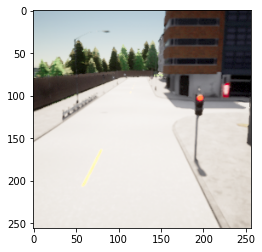

In [42]:
plt.imshow(train_data[1])

In [4]:
type(train_data)

numpy.ndarray

In [5]:
## transpose images

def discardLabels(data):
    x = 0
    new_data = []
    for img in data:
#         img = img.numpy()
        img = np.transpose(img, (2,1,0))
        new_data.append(img)
        x+=1
        if x == 40:
            return np.array(new_data)
        
    return np.array(new_data)

train_data = torch.as_tensor(discardLabels(train_data))
test_data = torch.as_tensor(discardLabels(test_data))

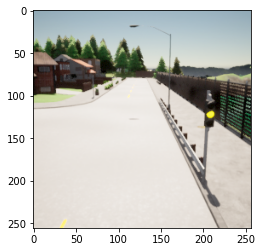

In [6]:
img = train_data[12]
img = img.numpy()
img = np.transpose(img, (2,1,0))
plt.imshow(img)

In [7]:
x = np.array([train_data[0], train_data[0], train_data[1]])

/tmp/fzi-is789/ipykernel_2036489/4156633873.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.array([train_data[0], train_data[0], train_data[1]])
/tmp/fzi-is789/ipykernel_2036489/4156633873.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array([train_data[0], train_data[0], train_data[1]])


In [8]:
# def check_Duplicates(data):
#     globalCounter = 0
#     for x in range(len(data)):
#         counter = 0
#         img = data[x]
#         for y in range(len(data)):
#             if not x == y:
#                 tmp = data[y] - img
#                 if np.sum(tmp) == 0:
#                     counter += 1
#                     globalCounter += 1
#         print(counter)
#     print(f"Gesamt: {globalCounter}")

In [9]:
# check_Duplicates(train_data)

In [10]:
## apply noise
noise_set = []

for img in test_data:
    pic = img.numpy().copy()
    pic[:,250:310,200:350] = 0.0
    noise_set.append(pic)

noise_set = np.array(noise_set)
noise_set = torch.as_tensor(noise_set)
noise_set.shape

torch.Size([20, 3, 256, 256])

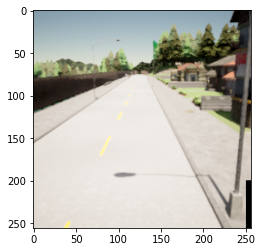

In [11]:
## show noisy image

img = noise_set[11]
# img = img.squeeze()
img = img.numpy()
img = np.transpose(img, (2,1,0))
plt.imshow(img)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [13]:

class VAE(nn.Module):
    
    def __init__(self, imgChannels=3, imgSize=parameters["imgSize"], zDim=parameters["zDim"]):
        super(VAE, self).__init__()
        
        
        stride=[1,1,1,2,1,2,1,2,2,2,2]
        out_stride=[2,2,2,2,1,2,1,2,1,1,1]
#         in_stride=[1,2,2,2,2]
#         out_stride=[1,2,2,2,1]
        in_padding=[1,0,0,0,0,0,0,0,0,0,0]
        in_trans_padding=[0,0,0,0,0,0,0,0,0,0,0]
        out_padding=[0,0,0,0,0,0,0,0,0,0,0]
        kernel=[3,3,3,3,3,3,3,3,3,3,3]
        kernel_out=[4,4,3,3,3,3,3,3,4,3,1]
#         layers=[128, 128, 128, 256, 256]
        layers=parameters["layers"]
        layers_out = parameters["layers_out"]
#         layers=[32, 64, 64, 128, 128]
#         layers=[64, 128, 128, 128, 256]
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
#         self.SkipCon1 = nn.Conv2d(in_channels=imgChannels, out_channels=layers[0], kernel_size=1, stride=1, padding=0)
        self.encConv1 = nn.Conv2d(in_channels=imgChannels, out_channels=layers[0], kernel_size=kernel[0], stride=stride[0], padding=in_padding[0])
        self.encBn1 = nn.BatchNorm2d(layers[0])
        self.encConv2 = nn.Conv2d(in_channels=layers[0], out_channels=layers[1], kernel_size=kernel[1], stride=stride[1], padding=in_padding[1])
        self.encBn2 = nn.BatchNorm2d(layers[1])
        self.encConv3 = nn.Conv2d(in_channels=layers[1], out_channels=layers[2], kernel_size=kernel[2], stride=stride[2], padding=in_padding[2])
        self.encBn3 = nn.BatchNorm2d(layers[2])
        self.encConv4 = nn.Conv2d(in_channels=layers[2], out_channels=layers[3], kernel_size=kernel[3], stride=stride[3], padding=in_padding[3])
        self.encBn4 = nn.BatchNorm2d(layers[3])
        self.encConv5 = nn.Conv2d(in_channels=layers[3], out_channels=layers[4], kernel_size=kernel[4], stride=stride[4], padding=in_padding[4])
        self.encBn5 = nn.BatchNorm2d(layers[4])
        self.encConv6 = nn.Conv2d(in_channels=layers[4], out_channels=layers[5], kernel_size=kernel[5], stride=stride[5], padding=in_padding[5])
        self.encBn6 = nn.BatchNorm2d(layers[5])
        self.encConv7 = nn.Conv2d(in_channels=layers[5], out_channels=layers[6], kernel_size=kernel[6], stride=stride[6], padding=in_padding[6])
        self.encBn7 = nn.BatchNorm2d(layers[6])
        self.encConv8 = nn.Conv2d(in_channels=layers[6], out_channels=layers[7], kernel_size=kernel[7], stride=stride[7], padding=in_padding[7])
        self.encBn8 = nn.BatchNorm2d(layers[7])
        self.encConv9 = nn.Conv2d(in_channels=layers[7], out_channels=layers[8], kernel_size=kernel[8], stride=stride[8], padding=in_padding[8])
        self.encBn9 = nn.BatchNorm2d(layers[8])
        self.encConv10 = nn.Conv2d(in_channels=layers[8], out_channels=layers[9], kernel_size=kernel[9], stride=stride[9], padding=in_padding[9])
        self.encBn10 = nn.BatchNorm2d(layers[9])
        self.encConv11 = nn.Conv2d(in_channels=layers[9], out_channels=layers[10], kernel_size=kernel[10], stride=stride[10], padding=in_padding[10])
        self.encBn11 = nn.BatchNorm2d(layers[10])
        
        encoderDims = self.calcEncoderDims(len(layers), imgSize, kernel, in_padding, stride)
        featureDim = layers[-1] * encoderDims[-1] * encoderDims[-1]
        self.encFC1 = nn.Linear(featureDim, zDim)

        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBn1 = nn.BatchNorm1d(featureDim)
        self.decConv1 = nn.ConvTranspose2d(in_channels=layers_out[0], out_channels=layers_out[1], kernel_size=kernel_out[0], stride=out_stride[0], padding=in_trans_padding[0], output_padding=out_padding[0])
        self.decBn2 = nn.BatchNorm2d(layers_out[1])
        self.decConv2 = nn.ConvTranspose2d(in_channels=layers_out[1], out_channels=layers_out[2], kernel_size=kernel_out[1], stride=out_stride[1], padding=in_trans_padding[1], output_padding=out_padding[1])
        self.decBn3 = nn.BatchNorm2d(layers_out[2])
        self.decConv3 = nn.ConvTranspose2d(in_channels=layers_out[2], out_channels=layers_out[3], kernel_size=kernel_out[2], stride=out_stride[2], padding=in_trans_padding[2], output_padding=out_padding[2])
        self.decBn4 = nn.BatchNorm2d(layers_out[3])
        self.decConv4 = nn.ConvTranspose2d(in_channels=layers_out[3], out_channels=layers_out[4], kernel_size=kernel_out[3], stride=out_stride[3], padding=in_trans_padding[3], output_padding=out_padding[3])
        self.decBn5 = nn.BatchNorm2d(layers_out[4])
        self.decConv5 = nn.ConvTranspose2d(in_channels=layers_out[4], out_channels=layers_out[5], kernel_size=kernel_out[4], stride=out_stride[4], padding=in_trans_padding[4], output_padding=out_padding[4])
        self.decBn6 = nn.BatchNorm2d(layers_out[5])
        self.decConv6 = nn.ConvTranspose2d(in_channels=layers_out[5], out_channels=layers_out[6], kernel_size=kernel_out[5], stride=out_stride[5], padding=in_trans_padding[5], output_padding=out_padding[5])
        self.decBn7 = nn.BatchNorm2d(layers_out[6])
        self.decConv7 = nn.ConvTranspose2d(in_channels=layers_out[6], out_channels=layers_out[7], kernel_size=kernel_out[6], stride=out_stride[6], padding=in_trans_padding[6], output_padding=out_padding[6])
        self.decBn8 = nn.BatchNorm2d(layers_out[7])
        self.decConv8 = nn.ConvTranspose2d(in_channels=layers_out[7], out_channels=layers_out[8], kernel_size=kernel_out[7], stride=out_stride[7], padding=in_trans_padding[7], output_padding=out_padding[7])
        self.decBn9 = nn.BatchNorm2d(layers_out[8])
        self.decConv9 = nn.ConvTranspose2d(in_channels=layers_out[8], out_channels=layers_out[9], kernel_size=kernel_out[8], stride=out_stride[8], padding=in_trans_padding[8], output_padding=out_padding[8])
        self.decBn10 = nn.BatchNorm2d(layers_out[9])
        self.decConv10 = nn.ConvTranspose2d(in_channels=layers_out[9], out_channels=layers_out[10], kernel_size=kernel_out[9], stride=out_stride[9], padding=in_trans_padding[9], output_padding=out_padding[9])
        self.decBn11 = nn.BatchNorm2d(layers_out[10])
        self.decConv11 = nn.ConvTranspose2d(in_channels=layers_out[10], out_channels=imgChannels, kernel_size=kernel_out[10], stride=out_stride[10], padding=in_trans_padding[10], output_padding=out_padding[10])
        
        
        self.final_encoder_dim = None
        
        decoderDims = self.calcDecoderDims(len(layers), encoderDims[-1], kernel_out, in_trans_padding, out_padding, out_stride)
        self.printModel(layers, layers_out, encoderDims, decoderDims, imgSize, imgChannels)

    def calcEncoderDims(self, layer_size, imageSize, kernel, in_padding, stride):
        newDims = [imageSize]
        for x in range(layer_size):
#             tmpSize = int((newDims[-1]-kernel[x]+2*in_padding[x])/stride[x])+1
            tmpSize = int(((newDims[-1] + 2*in_padding[x]-(kernel[x]-1)-1)/stride[x])+1)
            newDims.append(tmpSize)
        newDims.pop(0)
        return newDims
    
    def calcDecoderDims(self, layer_size, imageSize, kernel, in_trans_padding, out_padding, stride, d=1):
        newDims = [imageSize]
        for x in range(layer_size):            
            tmpSize = (newDims[-1] - 1)*stride[x] - 2*in_trans_padding[x] + d*(kernel[x] - 1) + out_padding[x] + 1
            newDims.append(tmpSize)
        newDims.pop(0)
        return newDims
    
    
    def printModel(self, layers, layers_out, encDims, decDims, imageSize, imgChannels):
        print("=============")
        print("Image Flow:")
        print("Encoder:")
        print(f"{imageSize}x{imageSize}x{imgChannels} (Input Image)")
        for x in range(len(layers)):
            print(f"{encDims[x]}x{encDims[x]}x{layers[x]}")
            
        print("++++ Latent Dim ++++")
        print(f"{encDims[-1]}x{encDims[-1]}x{layers[-1]}")
        print("++++ Latent Dim ++++")
        
        print("Decoder:")
        for x in range(len(layers_out)):
            print(f"{decDims[x]}x{decDims[x]}x{layers_out[x]}")
        print(f"{decDims[-1]}x{decDims[-1]}x{imgChannels} (Output Image)")
        print("=============")
    
    def get_Latent_Size(self):
        return encDims[-1]*encDims[-1]*layers[-1]
        
    def encoder(self, x):
#         self.en_pool1= nn.MaxPool2d(kernel_size=3, stride=2) 
#         self.en_pool2= nn.MaxPool2d(kernel_size=3, stride=2) 
#         self.en_pool3= nn.MaxPool2d(kernel_size=3, stride=2) 
#         self.en_pool4= nn.MaxPool2d(kernel_size=3, stride=2) 
#         self.pool5= nn.MaxPool2d(kernel_size=3, stride=2) 
#         self.pool6= nn.MaxPool2d(kernel_size=3, stride=2) 
#         self.pool7= nn.MaxPool2d(kernel_size=3, stride=2) 
        
        x1 = self.encConv1(x)
        x1 = F.leaky_relu(self.encBn1(x1))
#         res = self.SkipCon1(x)
#         x1 = torch.add(x1, res) #skip_conn
        
        x2 = self.encConv2(x1)
        x2 = F.leaky_relu(self.encBn2(x2))
#         res = self.en_pool1(x1)
#         res = torch.cat((res,res),dim=1)
#         x2 = torch.add(x2, res) #skip_conn
        
        x3 = self.encConv3(x2)
        x3 = F.leaky_relu(self.encBn3(x3))
#         res = self.en_pool2(x2)
#         res = torch.cat((res,res),dim=1)
#         x3 = torch.add(x3, res) #skip_conn
        
        x4 = self.encConv4(x3)
        x4 = F.leaky_relu(self.encBn4(x4))
#         res = self.en_pool3(x3)
#         res = torch.cat((res,res),dim=1)
#         x4 = torch.add(x4, res) #skip_conn
        
        x5 = self.encConv5(x4)
        x5 = F.leaky_relu(self.encBn5(x5))

        x6 = self.encConv6(x5)
        x6 = F.leaky_relu(self.encBn6(x6))
        
        x7 = self.encConv7(x6)
        x7 = F.leaky_relu(self.encBn7(x7))
        
        x8 = self.encConv8(x7)
        x8 = F.leaky_relu(self.encBn8(x8))
        
        x9 = self.encConv9(x8)
        x9 = F.leaky_relu(self.encBn9(x9))
        
        x10 = self.encConv10(x9)
        x10 = F.leaky_relu(self.encBn10(x10))
        
        x11 = self.encConv11(x10)
        x11 = F.leaky_relu(self.encBn11(x11))
        
        self.final_encoder_dim = np.array([x11.size(1), x11.size(2), x11.size(3)])
        flatten = np.prod(self.final_encoder_dim)

        z = x11.view(-1, flatten)
        z = self.encFC1(z)
        
#         return z
        return z


    def decoder(self, z):

        d1 = F.leaky_relu(self.decFC1(z))
        d1 = self.decBn1(d1)
        d1 = d1.view(-1, self.final_encoder_dim[0], self.final_encoder_dim[1], self.final_encoder_dim[2])
#         print(z.size())

        d2 = self.decConv1(d1)
        d2 = F.leaky_relu(self.decBn2(d2))
#         print(d2.size())
        
        d3 = self.decConv2(d2)
        d3 = F.leaky_relu(self.decBn3(d3))
#         print(d3.size())
        
        d4 = self.decConv3(d3)
        d4 = F.leaky_relu(self.decBn4(d4))
#         print(d4.size())
        
        d5 = self.decConv4(d4)
        d5 = F.leaky_relu(self.decBn5(d5))
#         print(d5.size())
        
        d6 = self.decConv5(d5)
        d6 = F.leaky_relu(self.decBn6(d6))
#         print(d6.size())
        
        d7 = self.decConv6(d6)
        d7 = F.leaky_relu(self.decBn7(d7))
#         print(d7.size())
        
        d8 = self.decConv7(d7)
        d8 = F.leaky_relu(self.decBn8(d8))
#         print(d8.size())

        d9 = self.decConv8(d8)
        d9 = F.leaky_relu(self.decBn9(d9))

        d10 = self.decConv9(d9)
        d10 = F.leaky_relu(self.decBn10(d10))
        
        d11 = self.decConv10(d10)
        d11 = F.leaky_relu(self.decBn11(d11))
        
        d12 = torch.sigmoid(self.decConv11(d11))
        
        return d12

    def forward(self, x):

        z = self.encoder(x)

        out = self.decoder(z)
        return out
    
#     def residual(self, x, out_channels, stride=2, kernel=1, padding=1):
#         conv = nn.Conv2d(in_channels=imgChannels, out_channels=out_channels, kernel_size=kernel, stride=stride, padding=padding)

In [14]:
# model = VAE()
# model.to(device)
# model.load_state_dict(torch.load(PATH))

In [22]:

def loss_fn(x, recon_x):
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024), reduction = "sum")
#     Recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024)) * 32 * 32
    imgSize = parameters["imgSize"]
    BC_loss = F.cross_entropy(recon_x.view(-1, imgSize*imgSize), x.view(-1, imgSize*imgSize), reduction = "sum")
#     KLD_loss = 1 + log_var - mu.pow(2) - log_var.exp()
#     KLD_loss = torch.sum(KLD_loss)
#     KLD_loss *= -0.5
#     return torch.mean(Recon_loss + KLD_loss)
#     Recon_loss = F.mse_loss(recon_x.view(-1, 2500), x.view(-1, 2500), reduction = "sum") * 32 * 32 *3
    Recon_loss = F.mse_loss(recon_x.view(-1, imgSize*imgSize), x.view(-1, imgSize*imgSize), reduction = "sum")
    return BC_loss, Recon_loss
#     return Recon_loss_adapted, Recon_loss


In [23]:
model = VAE()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params}")

Image Flow:
Encoder:
256x256x3 (Input Image)
256x256x32
254x254x64
252x252x64
125x125x128
123x123x128
61x61x128
59x59x256
29x29x256
14x14x512
6x6x512
2x2x250
++++ Latent Dim ++++
2x2x250
++++ Latent Dim ++++
Decoder:
6x6x250
14x14x512
29x29x512
59x59x256
61x61x256
123x123x128
125x125x128
251x251x128
254x254x64
256x256x64
256x256x32
256x256x3 (Output Image)
Trainable params: 15800617


cuda


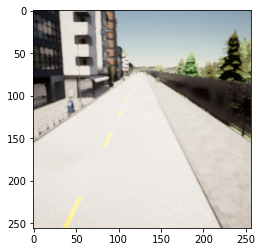

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torch.utils.data import DataLoader

dataloaders = {}
dataloaders["train"] = DataLoader(dataset=train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["test"] = DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["noise"] = DataLoader(dataset=noise_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

images = next(iter(dataloaders["test"]))
plt.imshow(np.transpose(images[0], (2,1,0)))


In [18]:
def evalOnSet(data):
    avg_MSE = 0
    for x in data:
        true_img = img.numpy()
        img = np.array([true_img])
        img = torch.as_tensor(img)
        img = img.to(device)
        out, _, _ = model(img)
        out = out[0].detach().cpu().numpy()
        errorMatrix = np.absolute(true_img - out)
        errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1] * errorMatrix.shape[2])
        avg_MSE += errorAvg
    return avg_MSE / len(data)

In [19]:
len(dataloaders["train"].dataset)

20

In [20]:
import random

def make_prediction(dataSet, index):
    model.eval()
    with torch.no_grad():
        imgs = torch.as_tensor(np.array([dataSet[index].numpy()]))
        print(imgs.shape)
        imgs = imgs.to(device)
    #         img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (2,1,0))

        out = model(imgs)
    #         outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        out = out[0].cpu().numpy()
        out = np.transpose(out, (2,1,0))

        #plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        ax1.set_title("Original")
        ax1.imshow(img)
        ax2.set_title("Reconstruction")
        ax2.imshow(out)
        return fig

In [24]:
train_losses = []
val_losses = []

reducer = []
for cutter in REDUCE_THRESHOLD:
    reducer.append(int(epoch * cutter))

print("Training started!")

for e in range(1, epoch+1):
    for reduce in reducer:    
        if e == reduce:
            for g in optimizer.param_groups:
                g['lr'] = learning_rate / 10
            print("Changed learningrate")

    train_loss = 0.0
    for x in dataloaders["train"]:
        x = x.to(device)
        x_recon = model(x)

        optimizer.zero_grad()
        loss, mse = loss_fn(x, x_recon)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    val_loss = 0.0
    for x in dataloaders["test"]:
        x = x.to(device)
        x_recon = model(x)

        optimizer.zero_grad()
        loss, mse = loss_fn(x, x_recon)

        val_loss += loss.item()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_loss /= len(dataloaders["train"].dataset)
    val_loss /= len(dataloaders["test"].dataset)

    print(f"Epoch {e} | Loss: {train_loss} | V_Loss: {val_loss} | MAE: {val_loss}")

Training started!
Epoch 1 | Loss: 1538359.8875 | V_Loss: 1537930.925 | MAE: 1537930.925
Epoch 2 | Loss: 1537698.025 | V_Loss: 1537437.9875 | MAE: 1537437.9875
Epoch 3 | Loss: 1537210.95 | V_Loss: 1536994.4875 | MAE: 1536994.4875
Epoch 4 | Loss: 1536770.9375 | V_Loss: 1536544.675 | MAE: 1536544.675
Epoch 5 | Loss: 1536319.7375 | V_Loss: 1536031.025 | MAE: 1536031.025
Changed learningrate
Epoch 6 | Loss: 1536007.45 | V_Loss: 1535999.825 | MAE: 1535999.825
Epoch 7 | Loss: 1535982.725 | V_Loss: 1535939.8875 | MAE: 1535939.8875
Changed learningrate
Epoch 8 | Loss: 1535887.575 | V_Loss: 1535883.8625 | MAE: 1535883.8625
Epoch 9 | Loss: 1535862.5 | V_Loss: 1535841.425 | MAE: 1535841.425
Epoch 10 | Loss: 1535802.4 | V_Loss: 1535743.65 | MAE: 1535743.65


## Evaluation Section

In [ ]:
model.eval()

In [ ]:
end_time = time.time()
time_elapsed = ((end_time - start_time) / 60.0) / 60.0
time_elapsed = int(time_elapsed * 100000)/ 100000.0

avg_mse = evalOnSet(test_data)
print(avg_mse)

file = open(PATH + "summary.txt", "w")
file.write("Train loss: " + str(train_losses[-1]) + " Val loss: " + str(val_losses[-1]))
file.write("\nEpochs: " + str(epoch))
file.write("\nBatchSize: " + str(BATCH_SIZE))
file.write("\nzDim: " + str(zDim))
file.write("\nAvg mse on test_data: " + str(avg_mse))
file.write("\nTime elapsed: " + str(time_elapsed) + " hours")

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses[15:],label="val")
plt.plot(train_losses[15:],label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(PATH + "loss_plot.svg")
plt.savefig(PATH + "loss_plot.png")
plt.show()

In [ ]:
def printReconError(img_in, img_out, threshold=None):
    img_in = img_in.dot([0.07, 0.72, 0.21])
    img_out = img_out.dot([0.07, 0.72, 0.21])
    errorMatrix = np.absolute(img_in - img_out)
    if not threshold == None:
        errorMatrix[errorMatrix < threshold] = 0.0
    errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1])
    print(f"MAE: {errorAvg}")
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    ax1.set_title("Original")
    ax1.imshow(img_in, cmap="gray")
    ax2.set_title("Recreation")
    ax2.imshow(img_out, cmap="gray")
    ax3.set_title("ErrorMap")
    ax3.imshow(errorMatrix, cmap="gray")

In [ ]:
import random

# model.eval()
with torch.no_grad():
    for imgs in random.sample(list(dataloaders["train"]), 1):
        imgs = imgs.to(device)
#         plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (2,1,0))
#         plt.imshow(img, cmap="gray")
        
        out, mu, logVAR = model(imgs)
#         plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (2,1,0))
#         plt.imshow(out, cmap="gray")
        
        printReconError(img, out, 0.0)
        break

In [ ]:
make_prediction(train_data, 0)

In [ ]:
make_prediction(test_data, 0)

In [ ]:
torch.save(model.state_dict(), PATH + "model.pt")

In [ ]:
input = torch.randn(3, 512, 512).numpy()
input = np.concatenate((input, np.zeros((29,512,512))))
input = torch.as_tensor(input)

In [ ]:
input = torch.randn(10, 3, 4)
mat2 = torch.randn(10, 4, 5)
res = input @ mat2
res.size()

In [ ]:
a = torch.randn(3, 257, 257)
k = torch.cat((a,a),dim=0)
k.shape